In [19]:
'''
Woody expt
Boudell_CO2_WoodyBiomass   we can remove the ALCE for failure to participate, 
we likely don't need the stem len and root len data since we do not have the full set of data for these factors
no germination data sheet yet b/c I want to organize it for the glmm
'''

"\nWoody expt\nBoudell_CO2_WoodyBiomass   we can remove the ALCE for failure to participate, \nwe likely don't need the stem len and root len data since we do not have the full set of data for these factors\nno germination data sheet yet b/c I want to organize it for the glmm\n"

In [20]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import eda_model_funcs as emf
import statsmodels
import statsmodels.formula.api as smf
# import pymer4  
sn.set_theme(style='darkgrid')

In [21]:
dfwt = pd.read_csv('woody_transplants_raw.csv')
dfwt.columns = ['num','species','chamber','shelf','water_lvl','rep','ag_biomass','bg_biomass','diam','stem_len','root_len','ag2','bg2']
dfwt = dfwt[dfwt.species != 'ALCE']

In [22]:
dfwt.head()

,num,species,chamber,shelf,water_lvl,rep,ag_biomass,bg_biomass,diam,stem_len,root_len,ag2,bg2
5,6,CEOC,1,TL,H,1,0.0077,0.0078,0.78,1.0,NaN,NaN,NaN
6,7,CEOC,1,TR,L,2,0.0205,0.0852,1.01,2.7,NaN,NaN,NaN
7,8,CEOC,1,TR,A,2,0.0127,0.0713,0.9,1.5,NaN,NaN,NaN
8,9,CEOC,1,B,H,3,0.0073,0.031,0.8,1.0,NaN,NaN,NaN
9,10,CEOC,1,TL,L,4,0.004,0.0057,0.56,1.3,NaN,NaN,NaN


In [26]:
dfwt.describe()

,num,chamber,rep,stem_len,root_len,ag2,bg2
count,144.000000,144.000000,144.000000,36.000000,1.0,5.000000,5.000000
mean,77.500000,2.500000,3.500000,3.819444,2.4,0.445900,0.262740
std,41.713307,1.121936,1.713786,6.772795,NaN,0.422535,0.258233
min,6.000000,1.000000,1.000000,0.800000,2.4,0.038100,0.018800
25%,41.750000,1.750000,2.000000,1.500000,2.4,0.055000,0.034500
50%,77.500000,2.500000,3.500000,1.950000,2.4,0.517200,0.296900
75%,113.250000,3.250000,5.000000,3.225000,2.4,0.559200,0.311400
max,149.000000,4.000000,6.000000,37.500000,2.4,1.060000,0.652100


In [27]:
dfwt.groupby(['chamber','shelf','species']).size()

chamber  shelf  species
1        B      CEOC       3
                POFR       3
                SAGO       3
                TACH       3
         TL     CEOC       3
                POFR       3
                SAGO       3
                TACH       3
         TR     CEOC       3
                POFR       3
                SAGO       3
                TACH       3
2        B      CEOC       3
                POFR       3
                SAGO       3
                TACH       3
         TL     CEOC       3
                POFR       3
                SAGO       3
                TACH       3
         TR     CEOC       3
                POFR       3
                SAGO       3
                TACH       3
3        B      CEOC       3
                POFR       3
                SAGO       3
                TACH       3
         TL     CEOC       3
                POFR       3
                SAGO       3
                TACH       3
         TR     CEOC       3
                POF

In [28]:
dfwt.isna().sum()
dfwt = dfwt.drop(columns = ['stem_len','root_len'])

In [29]:
spec = dfwt.species.unique()
print(spec)
for sp in spec:
    print('Species:', sp)
    print(dfwt[dfwt.species == sp].isna().sum())
    print('----------')

['CEOC' 'POFR' 'SAGO' 'TACH']
Species: CEOC
num            0
species        0
chamber        0
shelf          0
water_lvl      0
rep            0
ag_biomass     0
bg_biomass     2
diam           2
ag2           34
bg2           34
dtype: int64
----------
Species: POFR
num            0
species        0
chamber        0
shelf          0
water_lvl      0
rep            0
ag_biomass     0
bg_biomass     0
diam           0
ag2           36
bg2           36
dtype: int64
----------
Species: SAGO
num            0
species        0
chamber        0
shelf          0
water_lvl      0
rep            0
ag_biomass     0
bg_biomass     1
diam           1
ag2           33
bg2           33
dtype: int64
----------
Species: TACH
num            0
species        0
chamber        0
shelf          0
water_lvl      0
rep            0
ag_biomass     0
bg_biomass     0
diam           0
ag2           36
bg2           36
dtype: int64
----------


In [30]:
dfwt.dtypes

num             int64
species        object
chamber         int64
shelf          object
water_lvl      object
rep             int64
ag_biomass     object
bg_biomass     object
diam           object
ag2           float64
bg2           float64
dtype: object

In [31]:
#Feature Engineering
for col in ['ag_biomass','bg_biomass']:
    dfwt[col] = pd.to_numeric(dfwt[col], errors='coerce')
dfwt['total_biomass'] = dfwt.ag_biomass + dfwt.bg_biomass
dfwt['co2_lvl'] = np.select([dfwt.chamber.isin([1,2]), dfwt.chamber.isin([3,4])], ['Ambient','High'])
dfwt = dfwt.sort_values(['species','water_lvl','co2_lvl'])
dfwt.isna().sum()

num                0
species            0
chamber            0
shelf              0
water_lvl          0
rep                0
ag_biomass         3
bg_biomass         3
diam               3
ag2              139
bg2              139
total_biomass      3
co2_lvl            0
dtype: int64

In [32]:
dfwt.dropna(subset=['total_biomass']).groupby(['species','water_lvl','co2_lvl']).size()

species  water_lvl  co2_lvl
CEOC     A          Ambient    6
                    High       6
         H          Ambient    5
                    High       6
         L          Ambient    5
                    High       6
POFR     A          Ambient    6
                    High       6
         H          Ambient    6
                    High       6
         L          Ambient    6
                    High       6
SAGO     A          Ambient    5
                    High       6
         H          Ambient    6
                    High       6
         L          Ambient    6
                    High       6
TACH     A          Ambient    6
                    High       6
         H          Ambient    6
                    High       6
         L          Ambient    6
                    High       6
dtype: int64

In [33]:
dfwt.groupby(['co2_lvl','chamber','shelf']).size()

co2_lvl  chamber  shelf
Ambient  1        B        12
                  TL       12
                  TR       12
         2        B        12
                  TL       12
                  TR       12
High     3        B        12
                  TL       12
                  TR       12
         4        B        12
                  TL       12
                  TR       12
dtype: int64

<AxesSubplot:xlabel='species', ylabel='total_biomass'>

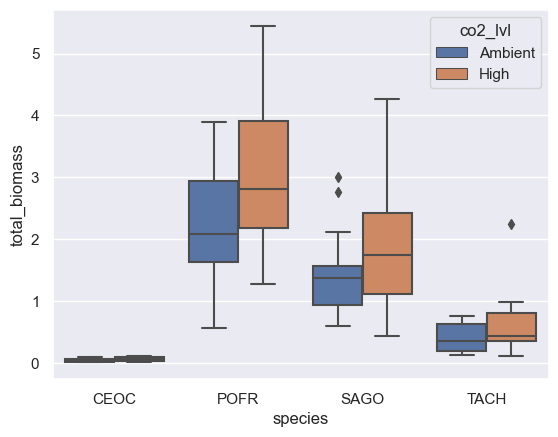

In [13]:
sn.boxplot(data=dfwt, x='species', y='total_biomass', hue='co2_lvl')

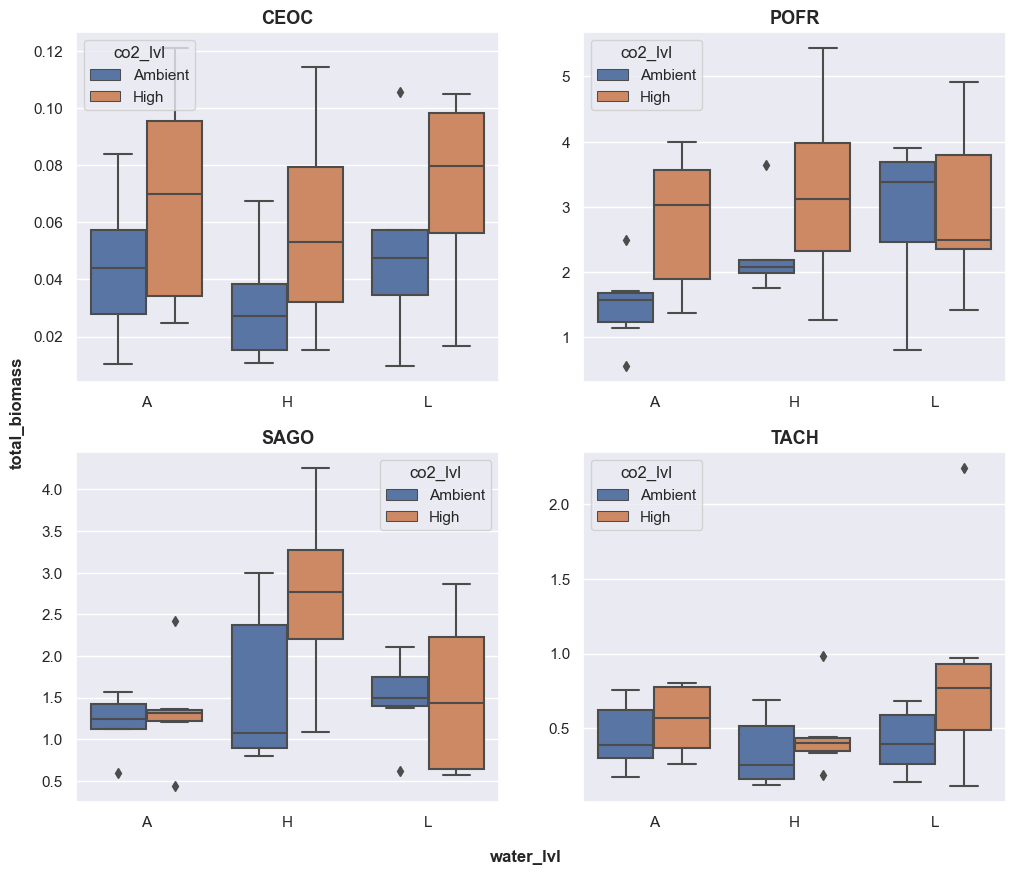

In [14]:
emf.plot_multiple_boxplots(dfwt, by = 'species', x = 'water_lvl', y = 'total_biomass', 
                           hue = 'co2_lvl', subplots = {'nrows':2, 'ncols':2, 'figsize':(12,10)})

In [15]:
# emf.plot_sidebyside_boxplots(dfwt, by = 'species', x = 'water_lvl', y1 = 'ag_biomass', y2 = 'bg_biomass', hue = 'co2_lvl')

In [18]:
#*** Should I rescale each species biomass to 0-1, 

df = dfwt.copy()
# df = df[df.species != 'MIGU']
df = df[df.co2_lvl.isna()==False]
df = df[df.total_biomass.isna()==False]

# df['co2_lvl'] = np.where(df.co2_lvl=='Ambient',0,1)
# df['water_lvl'] = np.select([df.water_lvl=='Low', df.water_lvl=='Fluct', df.water_lvl=='High'], [2,0,1])
# df['species'] = np.select([df.species=='MIGU', df.species=='NAOF', df.species=='VEAN', df.species=='POMO'], [0,1,2,3])
df['co2_lvl'] = np.where(df['co2_lvl'] == 'High', 1, 0)
df['water_low'] = np.where(df['water_lvl'] == 'L', 1, 0)
df['water_fluct'] = np.where(df['water_lvl'] == 'A', 1, 0)
df['water_high'] = np.where(df['water_lvl'] == 'H', 1, 0)

###Random effect is shelf

df['shelf'] = np.where(df['shelf'] == 'B', 1, df['shelf'])
df['shelf'] = np.where(df['shelf'] == 'TL', 2, df['shelf'])
df['shelf'] = np.where(df['shelf'] == 'TR', 3, df['shelf'])

#Export model ready data
df.to_csv('woody_transplants_model_rdy.csv')

In [60]:
# import statsmodels.formula.api as smf

# # model = smf.ols('total_biomass ~ co2_lvl', dfwt)
# model = smf.mixedlm('total_biomass ~ co2_lvl', dfwt, groups=dfwt['shelf'])
# res = model.fit()

# print(res.summary())

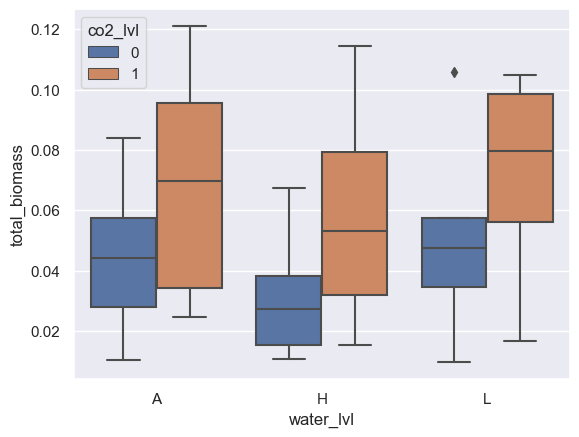

           Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: total_biomass
No. Observations:  34      Method:             REML         
No. Groups:        3       Scale:              0.0011       
Min. group size:   10      Log-Likelihood:     56.1379      
Max. group size:   12      Converged:          No           
Mean group size:   11.3                                     
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          0.039    0.010  3.942 0.000  0.020  0.058
co2_lvl            0.025    0.014  1.814 0.070 -0.002  0.051
water_low          0.012    0.018  0.696 0.487 -0.022  0.047
co2_lvl:water_low -0.003    0.024 -0.138 0.890 -0.050  0.043
Group Var          0.000    0.004                           



/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

In [62]:
ceoc = df[df.species=='CEOC']

sn.boxplot(data=ceoc, x='water_lvl', y='total_biomass', hue='co2_lvl')
plt.show()

# model = smf.ols('total_biomass ~ co2_lvl + co2_lvl*water_low + co2_lvl*water_high + co2_lvl*water_fluct', ceoc)
model = smf.mixedlm('total_biomass ~ co2_lvl', ceoc, groups=ceoc['shelf'], re_formula='co2_lvl', vc_formula={'chamber:shelf': '0 + C(student_id)'})
res = model.fit()

print(res.summary())

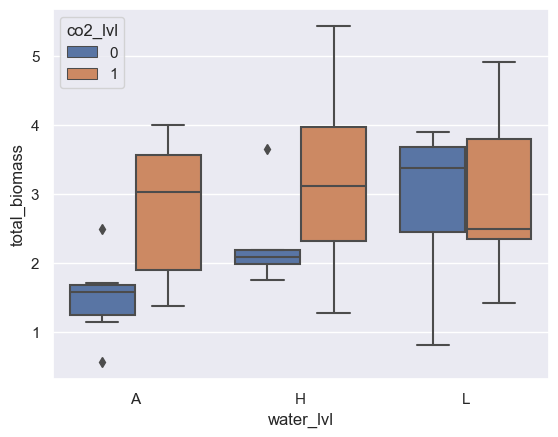

            Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: total_biomass
No. Observations:   36      Method:             REML         
No. Groups:         3       Scale:              1.1657       
Min. group size:    12      Log-Likelihood:     -50.8442     
Max. group size:    12      Converged:          Yes          
Mean group size:    12.0                                     
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           1.509    0.470  3.209 0.001  0.587  2.430
co2_lvl             1.277    0.623  2.049 0.040  0.056  2.499
water_low           1.391    0.623  2.232 0.026  0.170  2.613
co2_lvl:water_low  -1.199    0.882 -1.360 0.174 -2.927  0.529
water_high          0.781    0.623  1.253 0.210 -0.441  2.003
co2_lvl:water_high -0.357    0.882 -0.405 0.686 -2.085  1.371
Group Var           

In [64]:
pofr = df[df.species=='POFR']

sn.boxplot(data=pofr, x='water_lvl', y='total_biomass', hue='co2_lvl')
plt.show()

# model = smf.ols('total_biomass ~ co2_lvl + co2_lvl*water_low + co2_lvl*water_high + co2_lvl*water_fluct', pofr)
model = smf.mixedlm('total_biomass ~ co2_lvl + co2_lvl*water_low + co2_lvl*water_high', pofr, groups=pofr['shelf'])
res = model.fit()

print(res.summary())

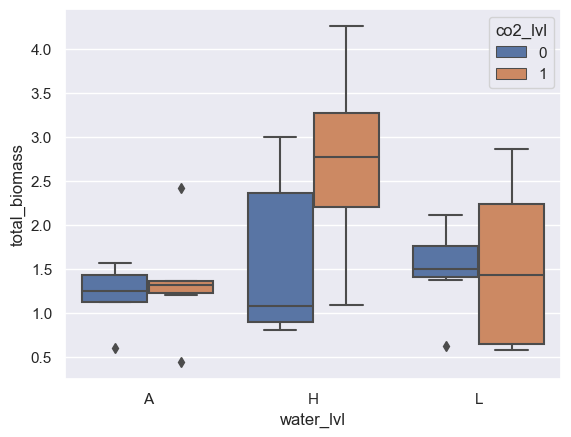

                            OLS Regression Results                            
Dep. Variable:          total_biomass   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     2.560
Date:                Sun, 29 Oct 2023   Prob (F-statistic):             0.0490
Time:                        12:23:42   Log-Likelihood:                -39.795
No. Observations:                  35   AIC:                             91.59
Df Residuals:                      29   BIC:                             100.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.0701    

In [42]:
sago = df[df.species=='SAGO']

sn.boxplot(data=sago, x='water_lvl', y='total_biomass', hue='co2_lvl')
plt.show()

model = smf.ols('total_biomass ~ co2_lvl + co2_lvl*water_low + co2_lvl*water_high + co2_lvl*water_fluct', sago)
res = model.fit()

print(res.summary())

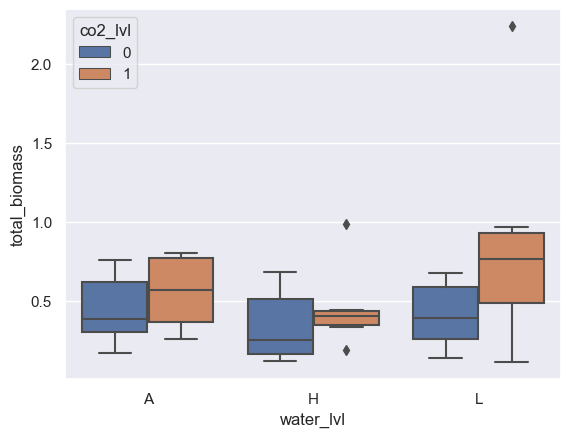

                            OLS Regression Results                            
Dep. Variable:          total_biomass   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     1.573
Date:                Sun, 29 Oct 2023   Prob (F-statistic):              0.198
Time:                        12:28:24   Log-Likelihood:                -12.157
No. Observations:                  36   AIC:                             36.31
Df Residuals:                      30   BIC:                             45.81
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.3015    

In [46]:
tach = df[df.species=='TACH']

sn.boxplot(data=tach, x='water_lvl', y='total_biomass', hue='co2_lvl')
plt.show()

model = smf.ols('total_biomass ~ co2_lvl + co2_lvl*water_low + co2_lvl*water_high + co2_lvl*water_fluct', tach)
res = model.fit()

print(res.summary())